# **Imports and defined functions**

## **Imports**

In [311]:
!pip install numpy==2.1

In [312]:
from itertools import cycle

# Libraries for data wrangling
import numpy as np
import pandas as pd

# Libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Libraries for data preparation
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

# Libraries for hyperparameters tuning and evaluation
import optuna
import shap
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import learning_curve
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from numpy import mean, std
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

# Libararies for ML
import xgboost as xgb
from xgboost import XGBClassifier

# Libraries for DL using PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

## **Defined functions**

In [313]:
def modelling(classifier, X_train, X_test, y_train, y_test):
    """
        This function trains a machine learning model based on scikit-learn functionality and computes accuracy score

            Parameters:
                classifier(sklearn.method): scikit-learn model to evaluate. Exaple: RandomForestClassifier()
                X_train(pd.DataFrame): Train sample
                X_test(pd.DataFrame): Test sample
                y_train(pd.DataFrame): Train target
                y_test(pd.DataFrame): Test target

            Returns: Fitted model, predicted values and accuracy score
                

    """
    classifier = classifier
    classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    return classifier, y_pred, accuracy

In [314]:
def evaluation(y_pred, y_test, show_percentage = False):
    """
        This function makes confusion matrix and classification report on test values

            Parameters:
                y_pred(pd.DataFrame): Predicted target
                y_test(pd.DataFrame): Test target
                show_percentage(bool): parameter to plot confusion matrix with perecentages. By default - False

            Returns: confusion matrix, accuracy score and classification report
                

    """
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    if show_percentage == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # для вычисления в процентном соотношении
        
    sns.heatmap(cm, annot = True, fmt='.4g')
    print('Accuracy: {}'.format(accuracy))
    print(classification_report(y_test, y_pred, digits = 5))

    return accuracy    

In [494]:
def plot_cumulative_chart(df, label, figsize = (8, 6)):
    
    plt.figure(figsize = figsize)
    plot = sns.lineplot(data = df)
    
    if label == 'Cumulative Gain':
        plt.plot([0, 99], [0, 1], 'k--', label = 'Random')
    elif label == 'Cumulative Lift':
        plt.plot([1, 99], [1, 1], 'k--', label = 'Random')
    
    plt.xlabel('Percentile', fontsize = 1)
    plt.ylabel(label)
    title = label + ' Curve'
    plt.title(title)
    
    for ind, label in enumerate(plot.get_xticklabels()):
        if ind % 10 == 0 or ind % 99 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    plt.legend()
    plt.grid(True)
    plt.show()

In [495]:
def cumulative_classification_responce_rate(y_true, y_prob):
    """
        Compute the cumulative responce rate for classification.
    """
    # Sort y_true based on predicted probabilities in descending order
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    n = len(y_true)
    cumulative_positive = np.cumsum(y_true_sorted)
    
    # Calculate cumulative percentage of actual positives
    cumulative_positive_percentage = cumulative_positive / n
        
    return cumulative_positive_percentage

In [496]:
def cumulative_classification_gain(y_true, y_prob):
    """
    Compute the cumulative gain for classification.
    """
    # Sort y_true based on predicted probabilities in descending order
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    n = len(y_true[y_true == 1])
    cumulative_positive = np.cumsum(y_true_sorted)
    
    # Calculate cumulative percentage of actual positives
    cumulative_positive_gain = cumulative_positive / n

    return cumulative_positive_gain

In [497]:
def classification_lift(y_true, y_pred):
    """
    Compute the lift for classification.
    """
    # Percentage of actual positives in the entire dataset
    baseline = np.mean(y_true)
    
    # Indices where the prediction is positive
    positive_pred_indices = np.where(y_pred == 1)
    
    # Percentage of actual positives in the predicted positive group
    model_success_rate = np.mean(y_true[positive_pred_indices])
    
    return model_success_rate / baseline

In [498]:
def cumulative_classification_lift(y_true, y_prob):
    """
    Compute the cumulative lift for classification.
    """
    # Sort y_true based on predicted probabilities in descending order
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    n = len(y_true)
    cumulative_positive = np.cumsum(y_true_sorted)
    
    # Calculate cumulative percentage of actual positives
    cumulative_positive_percentage = cumulative_positive / np.arange(1, n + 1)
    
    # Overall percentage of actual positives in the dataset
    overall_positive_percentage = np.sum(y_true) / n
    
    cumulative_lifts = cumulative_positive_percentage / overall_positive_percentage
    
    return cumulative_lifts

In [315]:
def plot_precision_recall(precisions, recalls, label = ''):
    label = label
    plt.plot(recalls, precisions, linewidth = 2, label = label)
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precision', fontsize = 16)
    plt.legend()
    plt.grid(True)

In [316]:
def plot_roc_curve(fpr, tpr, roc_auc_score, label):
    label = 'ROC AUC = %0.2f' % roc_auc_score + label
    plt.plot(fpr, tpr, linewidth = 2,  label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.legend()
    plt.grid(True)

In [317]:
def hist_and_boxplot(data, name, xlabel, ylabel, title):
    """
        This function makes a plot with histogram and boxplot of a column

            Parameters:
                data(pd.DataFrame): dataframe with data
                name(str): name of a column to build a plot from
                xlabel(str): name of xlabel
                ylabel(str): name of ylabel
                title(str): title of a plot 

            Returns:
                Makes a chart that consists of histogram and boxplot with mode, median and mean values

    """
    column = data[name]

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    fig.set_figheight(6)
    fig.set_figwidth(18)
    
    try:    
        mean=column.mean()
        median=column.median()
        mode=column.mode().values[0]
    except TypeError:
        pass

    sns.boxplot(data = data, x = name, ax = ax_box)
    ax_box.axvline(mean, color = 'r', linestyle = '--')
    ax_box.axvline(median, color = 'g', linestyle = '-')
    ax_box.axvline(mode, color = 'b', linestyle = '-')

    sns.histplot(data = data, x = name, ax = ax_hist, kde = True)
    ax_hist.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
    ax_hist.axvline(median, color = 'g', linestyle = '-', label = 'Median')
    ax_hist.axvline(mode, color = 'b', linestyle = '-', label = 'Mode')

    ax_hist.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation = 90)

    ax_box.set(xlabel='')
    
    plt.show()
    plt.close()

In [318]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32))
    # need to convert float64 to Long else 
    # will get the following error
    # RuntimeError: expected scalar type Long but found Float
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [319]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2, output_dim): # Инициализация скрытых слоев
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden1) # Кол-во входов без учета bias и кол-во скрытых нейронов соответственно
        self.layer2 = nn.Linear(num_hidden1, num_hidden2) # Кол-во скрытых нейронов первого слоя и кол-во скрытых нейронов второго слоя соответственно
        self.layer3 = nn.Linear(num_hidden2, output_dim) # Кол-во скрытых нейронов второго слоя и кол-во нейронов выходного слоя соответственно
        self.bm_1 = nn.BatchNorm1d(num_hidden1) # Для Batch Normalisation, 1d - значит работает с векторым представлением данных
        self.bm_2 = nn.BatchNorm1d(num_hidden2) # Для Batch Normalisation, 1d - значит работает с векторым представлением данных

    def forward(self, x): #
        x = self.layer1(x) # Пропускаем вектор значений через первый слой
        x = nn.functional.relu(x) # Пропускаем вектор значений через функцию активации ReLU
        x = self.bm_1(x) # Для Batch Normalisation после функции активации выходного слоя
        x = self.layer2(x) # Пропускаем вектор значений через второй слой
        x = nn.functional.relu(x) # Пропускаем вектор значений через функцию активации ReLU
        x = self.bm_2(x) # Для Batch Normalisation после функции активации выходного слоя
        x = self.layer3(x) # Пропускаем вектор значений через выходной слой
        x = nn.functional.softmax(x, dim = 1) # Пропускаем вектор значений через SoftMax-функцию для получения аналога вероятностей
        return x

# **Data preparation**

## **Train/test split**

In [320]:
list_of_columns = ['has_BranchOther_problem',
 'has_TrunkOther_problem',
 'has_Queens_borough',
 'problems_pca_component_4',
 'problems_pca_component_2',
 'haversine_manhattan_distance_to_poor_tree',
 'has_Brooklyn_borough',
 'zip_city_pca_component_4',
 'problems_count',
 'spc_common_pca_component_1',
 'spc_common_pca_component_5',
 'problems_pca_component_3',
 'has_Staten Island_borough',
 'has_Bronx_borough',
 'zip_city_pca_component_2',
 'zip_city_pca_component_1',
 'has_BranchLights_problem',
 'has_RootOther_problem',
 'spc_common_pca_component_2',
 'spc_common_pca_component_3',
 'spc_common_pca_component_7',
 'tree_dbh_wrangled',
 'nta_name_pca_component_3',
 'zip_city_pca_component_3',
 'has_Ridgewood_nta_name',
 'spc_common_pca_component_9',
 'has_Annadale-Huguenot-Prince Bay-Eltingville_nta_name',
 'problems_pca_component_5',
 'nta_name_pca_component_2',
 'has_TreesCount Staff_user_type']

In [321]:
path = "\\data\\data_balanced_wrangled.csv"
df = pd.read_csv(path)

In [322]:
label_encoding = {
    'Good': 0,
    'Fair': 1,
    'Poor': 2
}

In [323]:
df['health'] = df['health'].map(label_encoding)

definitions = list(label_encoding)
print(definitions)

['Good', 'Fair', 'Poor']


In [324]:
X = df[list_of_columns]
y = df['health']

# Creating Training and Test sets from the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

y_train_binarized = label_binarize(y_train, classes = [*range(3)])
y_test_binarized = label_binarize(y_test, classes = [*range(3)])

## **Validation data**

In [325]:
path = "\\data\\data_validation_wrangled.csv"
df_val = pd.read_csv(path)

In [326]:
df_val['health'] = df_val['health'].map(label_encoding)

definitions_val = list(label_encoding)
print(definitions)
print(df_val['health'].value_counts())

['Good', 'Fair', 'Poor']
health
0    41360
1     7672
2     2100
Name: count, dtype: int64


In [327]:
X_val = df_val.loc[:, df_val.columns != 'health'][list_of_columns]
y_val = df_val['health']

In [328]:
y_val_binarized = label_binarize(y_val, classes = [*range(3)])

# **Evaluation of XGBoost model**

## **Main Metrics**

In [330]:
best_params = {'n_estimators': 200,
               'eval_metric': 'merror',
               'max_depth': 2,
               'reg_alpha': 3,
               'reg_lambda': 1,
               'min_child_weight': 200,
               'gamma': 0.3,
               'learning_rate': 0.05,
               'colsample_bytree': 0.4,
               'subsample': 0.7}

xgb_clf, y_pred, accuracy = modelling(XGBClassifier(**best_params), X_train, X_test, y_train, y_test)
y_pred_scores = xgb_clf.predict_proba(X_test)
y_pred_binarized = label_binarize(y_pred, classes = [*range(3)])

Модель отдает предпочтение классам 0 и 2. Для класса 1 прогнозы хуже:

Accuracy: 0.5104267366385858
              precision    recall  f1-score   support

           0    0.49833   0.67958   0.57501      4828
           1    0.45034   0.27056   0.33804      4827
           2    0.56122   0.58111   0.57099      4827

    accuracy                        0.51043     14482
   macro avg    0.50330   0.51042   0.49468     14482
weighted avg    0.50330   0.51043   0.49468     14482



0.5104267366385858

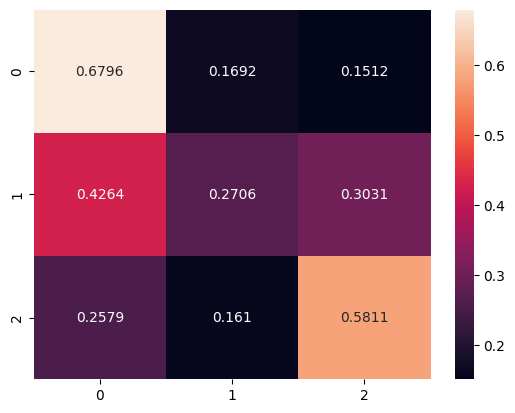

In [331]:
evaluation(y_pred, y_test, True)

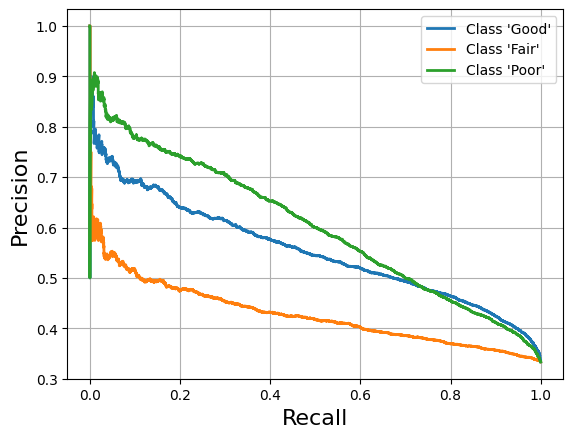

In [332]:
for i in range(3):
    xgb_precision, xgb_recall, thresholds = precision_recall_curve(y_test_binarized[:, i], y_pred_scores[:, i])
    label = 'Class ' + "'" + str(definitions[i]) + "'"
    plot_precision_recall(xgb_precision, xgb_recall, label)

В среднем модель все же лучше случайного отбора из всей совокупности:

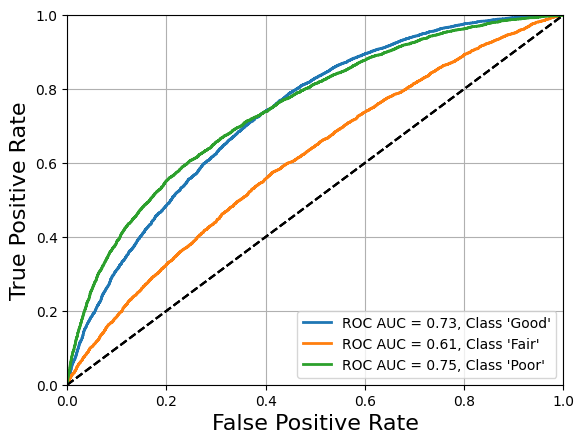

In [333]:
for i in range(3):
    fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test_binarized[:, i], y_pred_scores[:, i])
    xgb_roc_auc = roc_auc_score(y_test_binarized[:, i], y_pred_scores[:, i])
    label = ', Class ' + "'" + str(definitions[i]) + "'"
    plot_roc_curve(fpr_xgb, tpr_xgb, xgb_roc_auc, label)

In [334]:
res = []
for l in [0, 1, 2]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)== l,
                                                  np.array(y_pred) == l,
                                                  pos_label=True,average=None)
     res.append([l, recall[1], recall[0]])
    
pd.DataFrame(res,columns = ['class', 'sensitivity', 'specificity'])

,class,sensitivity,specificity
0,0,0.679577,0.657862
1,1,0.270561,0.834904
2,2,0.581106,0.772864


## **Gain, Responce Rate, Lift**

Дополнительно я использовал три метрики для оценки эффекта от внедрения модели. Данные метрики хорошо раскрывают себя, когда скоринговую совокупность дополнительно делят на сегменты исходя из плотности положительных классов. Для этого можно отсортировать все образцы по убыванию значения скоринга, после чего для первых перцентилей выделить high-propensity сегмент, для следующих - middle-propencity, оставшиеся - low-propencity. Для каждого сегмента считать следующие метрики:
- Responce Rate - доля положительных образцов среди всех образцов в сегменте.
- Gain - число положительных классов в сегменте к общему числу положительных классов во всей совокупности.
- Lift - соотношение Gain к количеству перцентелей в сегменте. Показывает во сколько раз модель лучше находит положительные классы, чем метод рандомного отбора.

По графикам «Response Rate», «Gain» и «Lift» видно, что для лучшего использования модели лучше делить прогнозы на сегменты в порядке убывания уверенности модели в том или ином классе. Например, показатель «Lift» для классов 0 и 2 в первых 10 перцентилях выше значения 2, что означает, что модель в два раза результативнее, чем случайный отбор классов из всей тестовой совокупности:

### **Responce Rate**

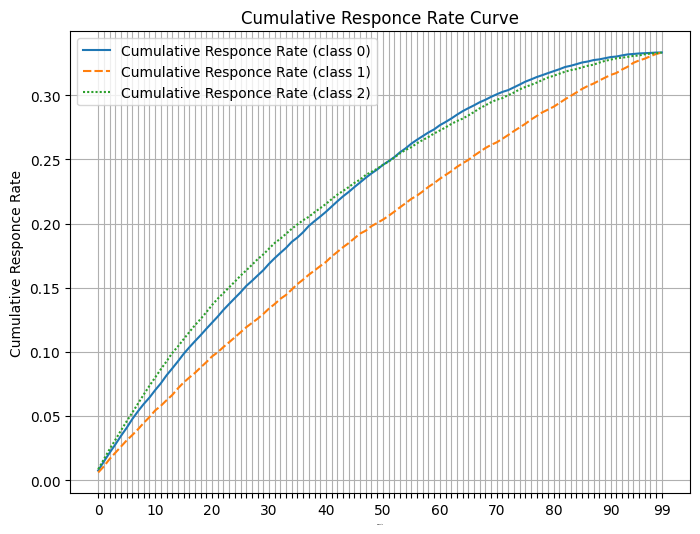

In [510]:
rr_df = pd.DataFrame()

for i in range(3):
    cumulative_rr_values = cumulative_classification_responce_rate(y_test_binarized[:, i], y_pred_scores[:, i])
    col_name = 'Cumulative Responce Rate (class ' + str(i) + ')'
    rr_df[col_name] = cumulative_rr_values

rr_df['bins'] = pd.qcut(rr_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
rr_df = rr_df.groupby(['bins'], observed = False).mean()

plot_cumulative_chart(rr_df, 'Cumulative Responce Rate')

### **Gain**

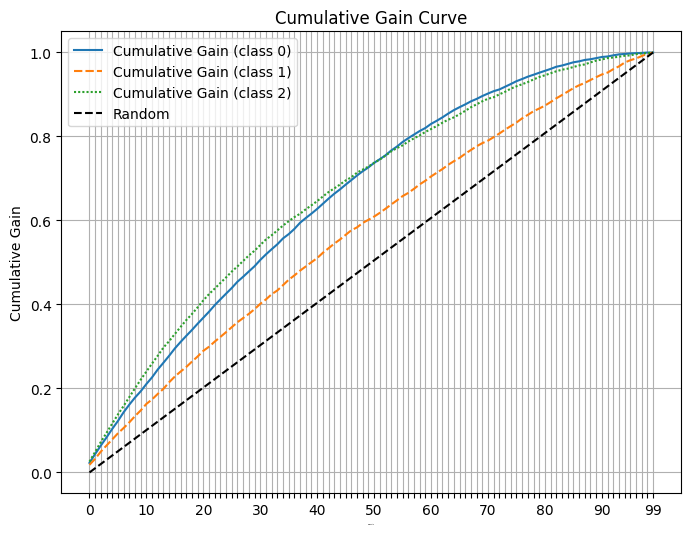

In [511]:
gain_df = pd.DataFrame()

for i in range(3):
    cumulative_gain_values = cumulative_classification_gain(y_test_binarized[:, i], y_pred_scores[:, i])
    col_name = 'Cumulative Gain (class ' + str(i) + ')'
    gain_df[col_name] = cumulative_gain_values

gain_df['bins'] = pd.qcut(gain_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
gain_df = gain_df.groupby(['bins'], observed = False).mean()

plot_cumulative_chart(gain_df, 'Cumulative Gain')

### **Lift**

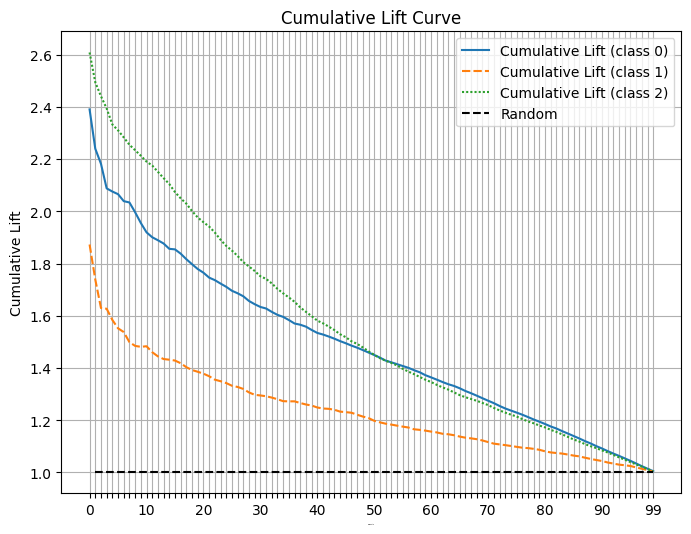

In [513]:
lift_df = pd.DataFrame()

for i in range(3):
    cumulative_lift_values = cumulative_classification_lift(y_test_binarized[:, i], y_pred_scores[:, i])
    col_name = 'Cumulative Lift (class ' + str(i) + ')'
    lift_df[col_name] = cumulative_lift_values

lift_df['bins'] = pd.qcut(lift_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
lift_df = lift_df.groupby(['bins'], observed = False).mean()

plot_cumulative_chart(lift_df, 'Cumulative Lift')

## **SHAP-values**

In [346]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

При помощи метода «SHAP» можно дополнительно оценить влияние каждой переменной на прогнозирование каждого класса. В совокупности наиболее важные переменные связаны с ближайшем расстоянием до дерева плохого качества, диаметр дерева, вид дерева, а также обнаруженные проблемы с деревом или его окружением:

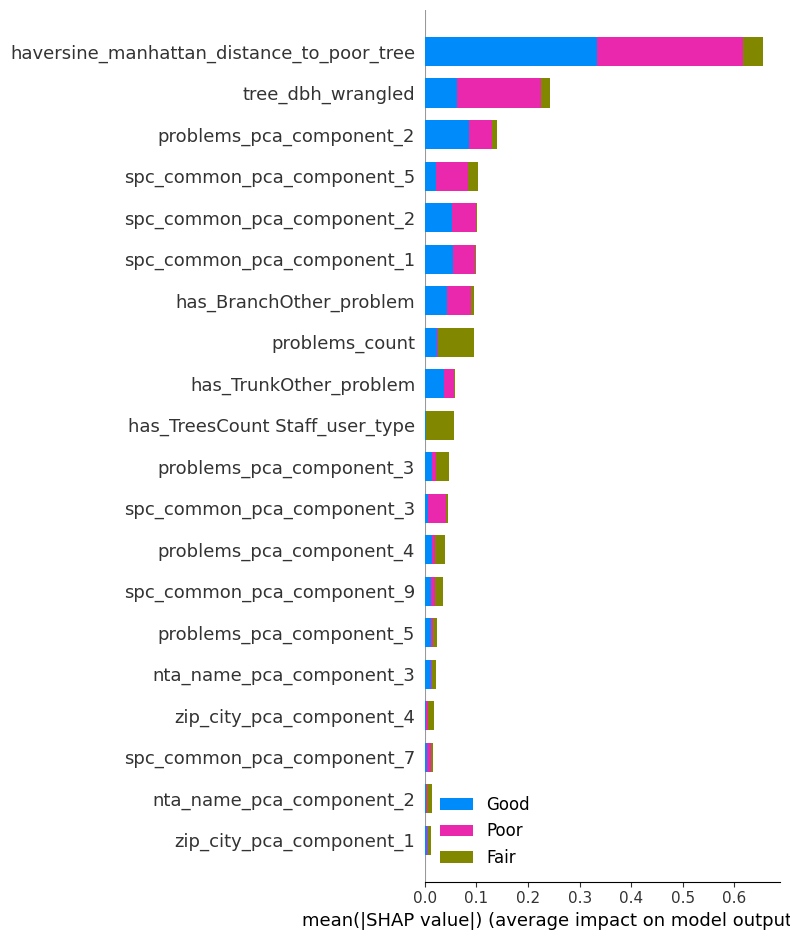

In [347]:
shap.summary_plot(shap_values, X_test, show = True, class_names = ['Good', 'Fair', 'Poor'])

### **Анализ для класса "Good"**

Для класса «Good» свойственны более большое расстояние до дерева плохого качества, меньшее число проблем с деревом, больший диаметр. 
Наличие большего диаметра, возможно, вызвано «ошибкой выжившего», когда старое дерево с большим диаметром смогло дожить до своего возраста и не было срублено. Нездоровые деревья были срублены, поэтому они в выборку не попали.
Также, вероятнее всего, деревья с аналогичным качеством кучкуются рядом друг с другом, поэтому рядом с хорошим деревом вероятнее встретить такое же хорошее дерево.

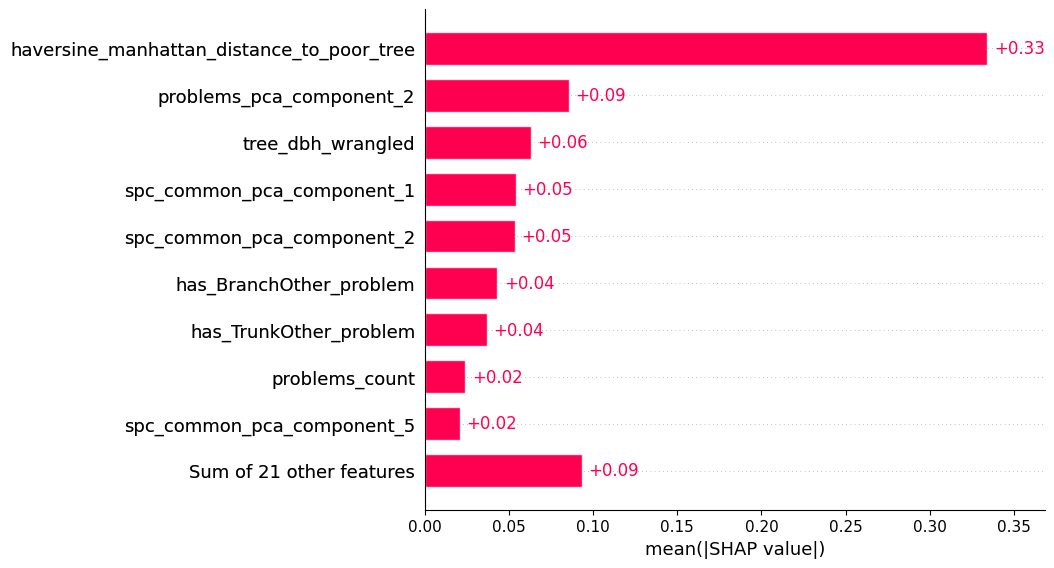

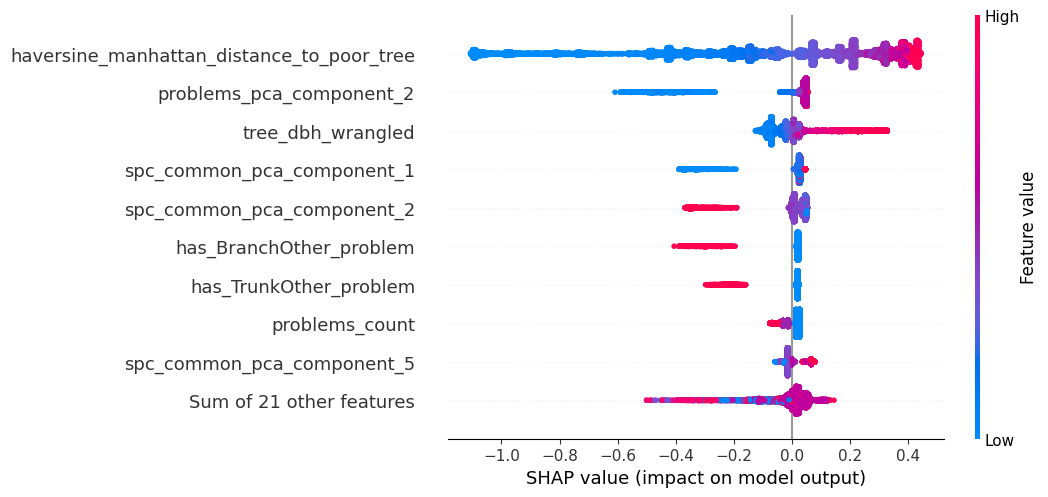

In [507]:
shap.plots.bar(shap_values[:, :, 0])
shap.plots.beeswarm(shap_values[:, :, 0])

### **Анализ для класса "Fair"**

Для класса «Fair» свойственны разные показатели. Данный класс включает в себя характеристики как хороших, так и плохих деревьев. В целом, небольшое число проблем, а также небольшое, но не наименьшее расстояние до дерева плохого качества характеризуют данный класс.

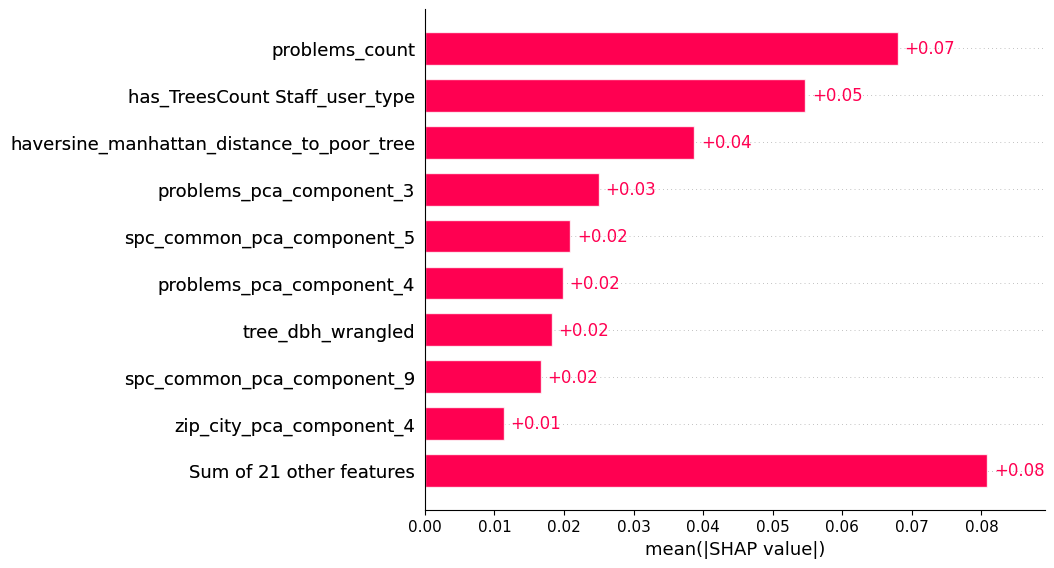

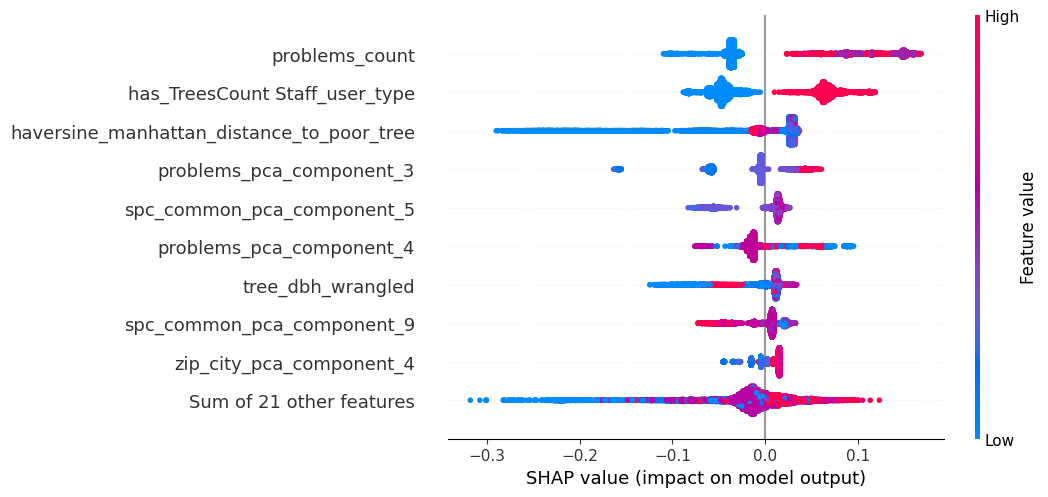

In [508]:
shap.plots.bar(shap_values[:, :, 1])
shap.plots.beeswarm(shap_values[:, :, 1])

### **Анализ для класса "Poor"**

Для класса «Poor» свойственны противоположные качества, чем у дерева класса «Good»: меньшее расстояние до дерева плохого качества, более большое число проблем с деревом, меньший диаметр. 

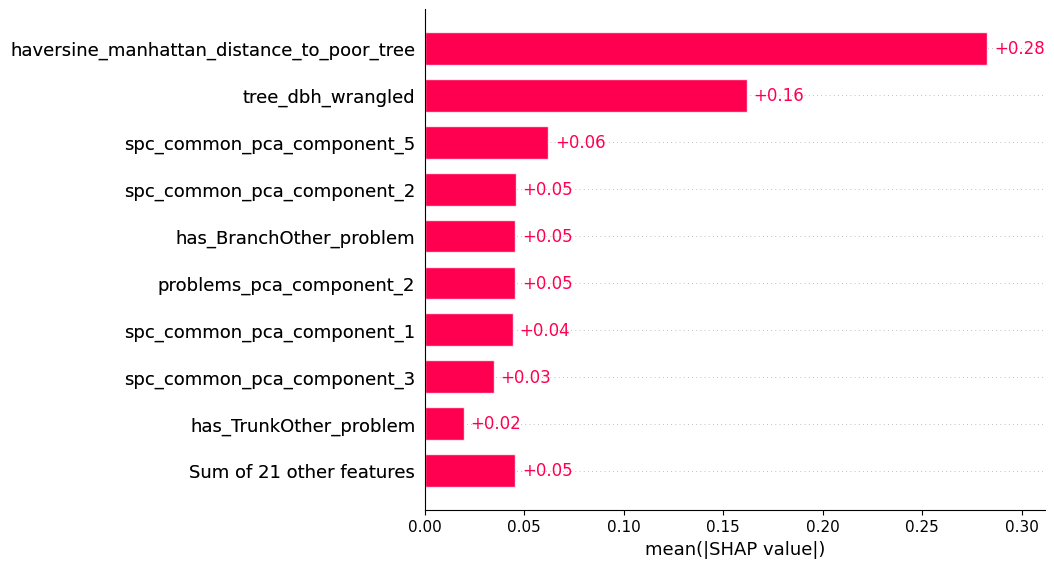

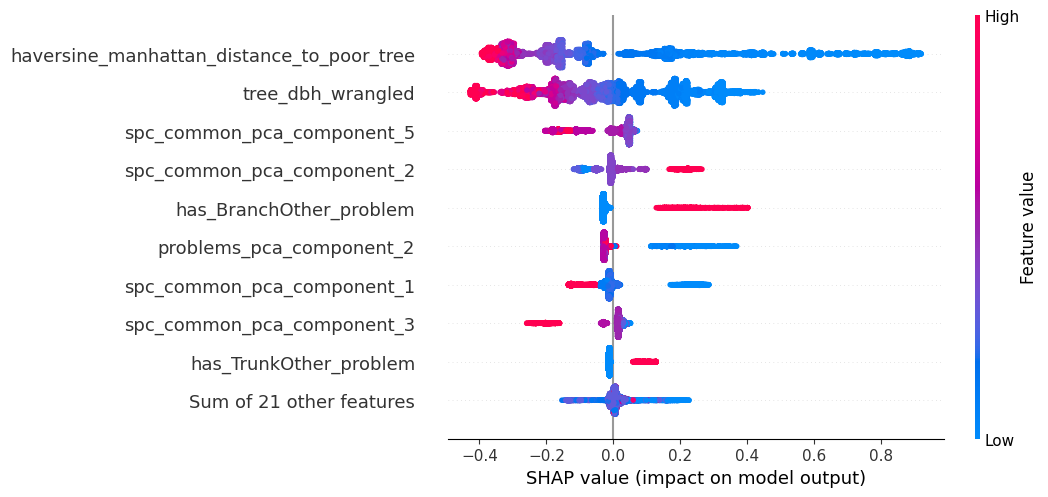

In [509]:
shap.plots.bar(shap_values[:, :, 2])
shap.plots.beeswarm(shap_values[:, :, 2])

## **Cross-validation**

Также некоторые метрики качества модели фиксировались на кросс-валидации. Всего было использовано два подхода:
Разбиение набора данных на 5 частей, где train/test чередуются.
Случайным образом данные разбивались на train/test в течении 100 случаев.
После таких разбиений модель обучалась, делала прогнозы на тестовой выборке, после чего метрики фиксировались.

Они показывают диапазоны, в которых метрики могут меняться из-за случайного фактора при разбиении выборки.

### **K-fold cross-validation**

In [42]:
scores = cross_validate(XGBClassifier(**best_params), X_train, y_train, scoring = ('precision_macro', 'recall_macro', 'f1_macro', 'accuracy'), n_jobs = 6, cv = 5)
scores

{'fit_time': array([2.23514795, 2.20782685, 2.20780802, 2.20351815, 2.26620078]),
 'score_time': array([0.03764439, 0.03450751, 0.03296041, 0.03774071, 0.03480196]),
 'test_precision_macro': array([0.49749086, 0.49416944, 0.49988309, 0.487598  , 0.48252134]),
 'test_recall_macro': array([0.50578284, 0.50405662, 0.51024479, 0.49970456, 0.49297114]),
 'test_f1_macro': array([0.48905925, 0.48971889, 0.49258659, 0.48320591, 0.47859574]),
 'test_accuracy': array([0.50578284, 0.50405662, 0.51022874, 0.49969789, 0.49296504])}

In [43]:
results = pd.DataFrame({'Metrics': list(scores), 'Mean': mean(list(scores.values()), axis = 1), 'Std': std(list(scores.values()), axis = 1)})
results['2 * Std'] = 2 * results['Std']
results['3 * Std'] = 3 * results['Std']
results['Mean - 3 * Std'] = results['Mean'] - results['3 * Std']
results['Mean + 3 * Std'] = results['Mean'] + results['3 * Std']
results

,Metrics,Mean,Std,2 * Std,3 * Std,Mean - 3 * Std,Mean + 3 * Std
0,fit_time,2.224100,0.023868,0.047736,0.071604,2.152497,2.295704
1,score_time,0.035531,0.001873,0.003746,0.005618,0.029913,0.041149
2,test_precision_macro,0.492333,0.006414,0.012827,0.019241,0.473092,0.511573
3,test_recall_macro,0.502552,0.005861,0.011723,0.017584,0.484968,0.520136
4,test_f1_macro,0.486633,0.005044,0.010088,0.015131,0.471502,0.501765
5,test_accuracy,0.502546,0.005860,0.011720,0.017580,0.484967,0.520126


### **Multiple evaluations on random splitted data**

In [44]:
iteration, precision, recall, F_measure, accuracy = [], [], [], [], []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
    xgb_clf_kfold, y_pred_kfold, accuracy_kfold = modelling(XGBClassifier(**best_params), X_train, X_test, y_train, y_test)
    precision_kfold, recall_kfold, F_measure_kfold, _ = precision_recall_fscore_support(y_test, y_pred_kfold, average = 'macro')

    iteration.append(i + 1)
    precision.append(precision_kfold)
    recall.append(recall_kfold)
    F_measure.append(F_measure_kfold)
    accuracy.append(accuracy_kfold)

In [45]:
results = pd.DataFrame({
    'iteration': iteration,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'F-measure': F_measure
})

In [46]:
results

,iteration,accuracy,precision,recall,F-measure
0,1,0.511739,0.503381,0.511727,0.496551
1,2,0.504972,0.495890,0.504988,0.489293
2,3,0.509391,0.501421,0.509408,0.492787
3,4,0.506767,0.498759,0.506783,0.492656
4,5,0.502624,0.494182,0.502640,0.487510
...,...,...,...,...,...
95,96,0.499309,0.490728,0.499299,0.484715
96,97,0.500691,0.492422,0.500679,0.485263
97,98,0.504765,0.495225,0.504753,0.487706
98,99,0.498826,0.488903,0.498814,0.482126


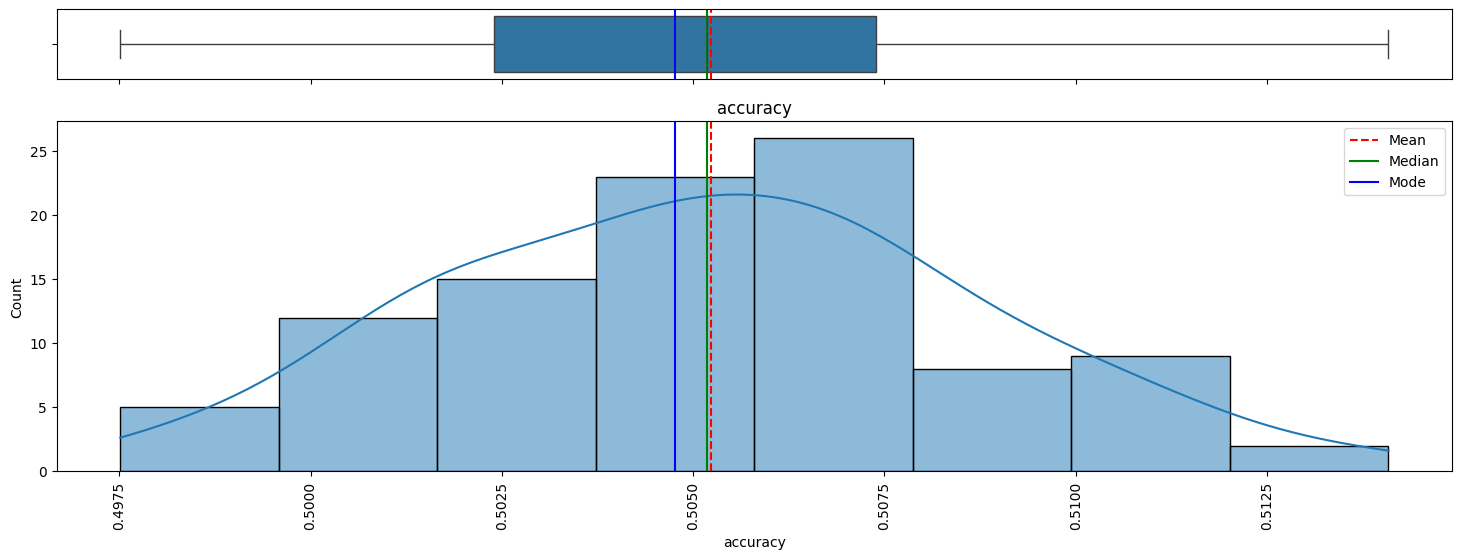

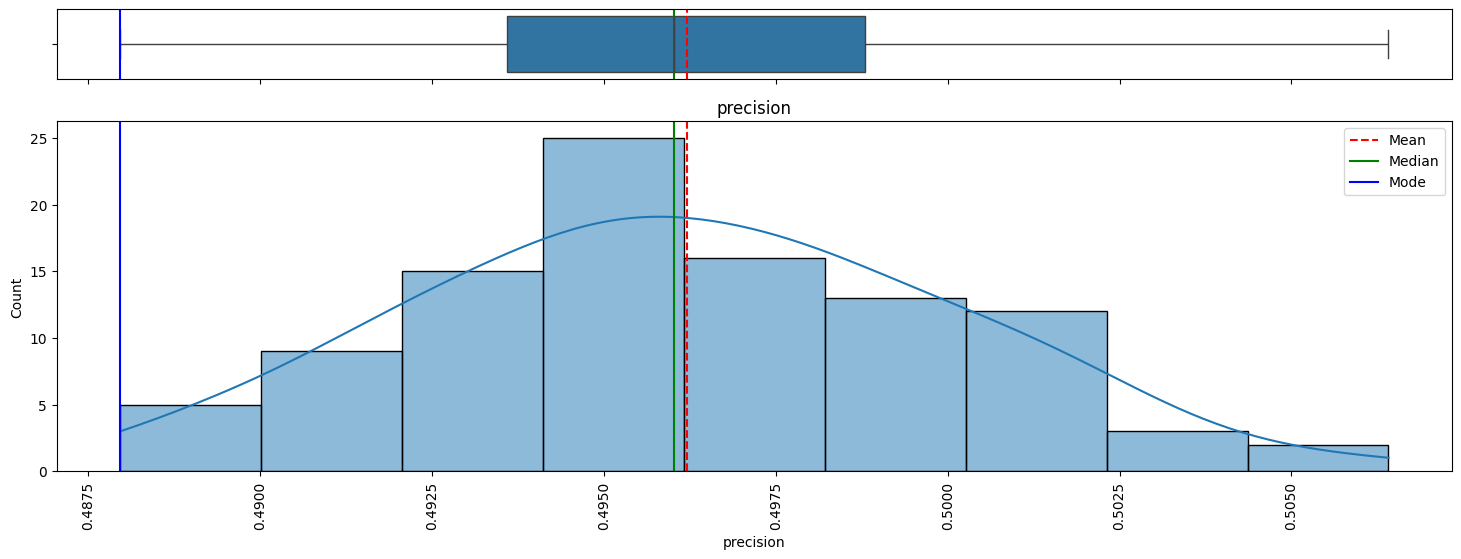

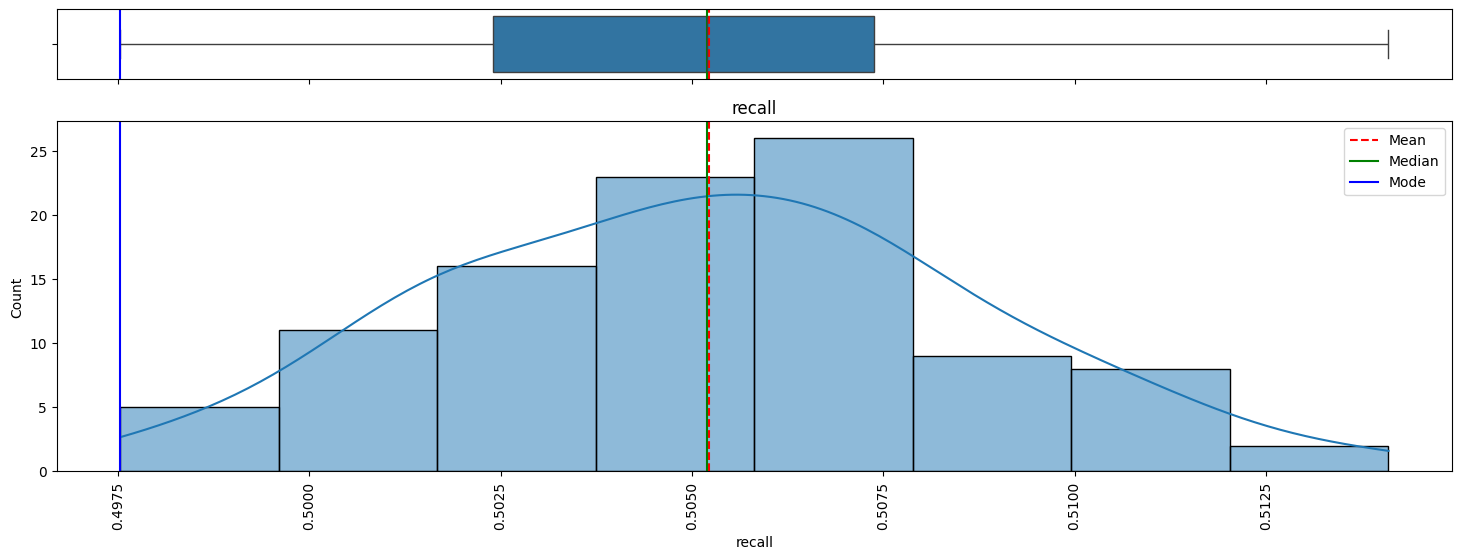

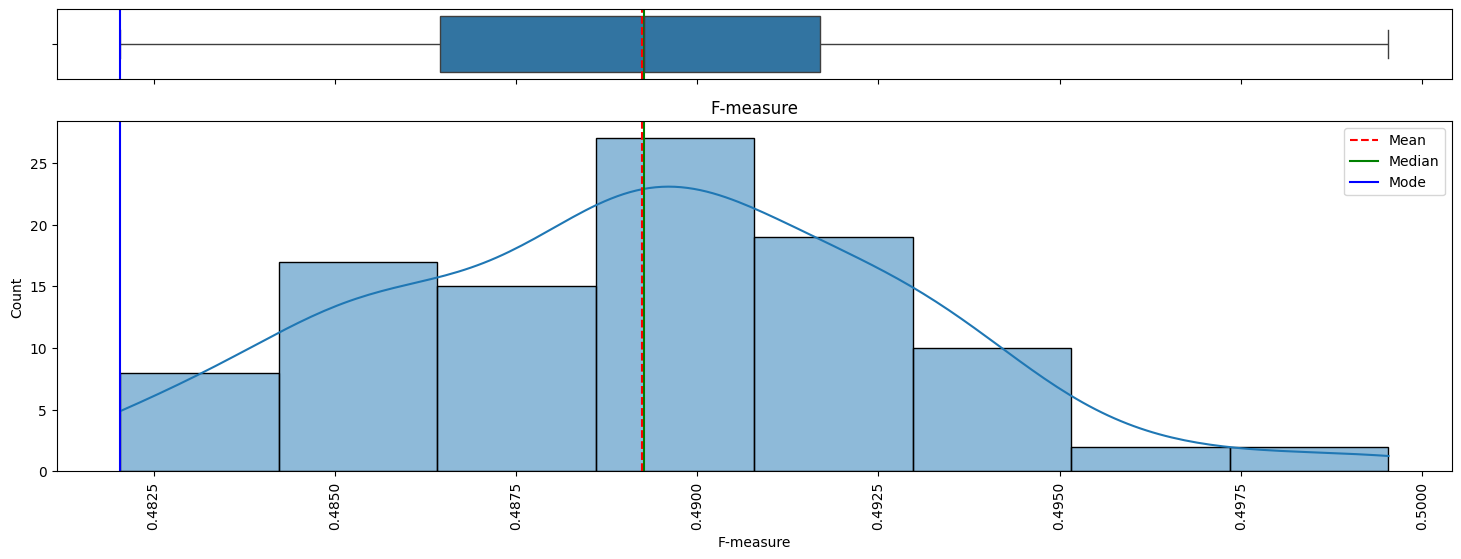

In [47]:
for i in range(1, 5):
    hist_and_boxplot(results, results.columns[i], results.columns[i], 'Count', results.columns[i])

In [48]:
results.columns[1:]

Index(['accuracy', 'precision', 'recall', 'F-measure'], dtype='object')

In [49]:
results_aggregated = pd.DataFrame({
    'Metrics': results.columns[1:],
    'Mean': results.mean(axis = 0)[1:],
    'Std': results.std(axis = 0)[1:],
    'Min': results.min(axis = 0)[1:],
    'Max': results.max(axis = 0)[1:]
})
results_aggregated['Mean - 3 Std'] = results_aggregated['Mean'] - 3 * results_aggregated['Std']
results_aggregated['Mean + 3 Std'] = results_aggregated['Mean'] + 3 * results_aggregated['Std']
results_aggregated

,Metrics,Mean,Std,Min,Max,Mean - 3 Std,Mean + 3 Std
accuracy,accuracy,0.505229,0.003484,0.497514,0.514086,0.494778,0.515681
precision,precision,0.496202,0.003860,0.487965,0.506412,0.484623,0.507780
recall,recall,0.505229,0.003484,0.497530,0.514103,0.494776,0.515682
F-measure,F-measure,0.489243,0.003636,0.482041,0.499538,0.478334,0.500152


## **Validation**

Ниже приведены результаты для валидационной выборки:

In [354]:
y_val_pred = xgb_clf.predict(X_val)
y_val_pred_scores = xgb_clf.predict_proba(X_val)
y_val_pred_binarized = label_binarize(y_val_pred, classes = [*range(3)])

Выборка несбалансирована и олицетворяет распределение в исходной совокупности, поэтому и прогнозы вышли разные:

In [355]:
unique, counts = np.unique(y_val_pred, return_counts = True)
dict(zip(unique, counts))

{np.int64(0): np.int64(32208),
 np.int64(1): np.int64(6294),
 np.int64(2): np.int64(12630)}

Видно, что модель неплохо прогнозирует классы 0 и 2 ("Good" и "Poor"), что достаточно неплохо:

Accuracy: 0.5901001329891262
              precision    recall  f1-score   support

           0    0.86336   0.67232   0.75595     41360
           1    0.18700   0.15342   0.16855      7672
           2    0.09414   0.56619   0.16144      2100

    accuracy                        0.59010     51132
   macro avg    0.38150   0.46397   0.36198     51132
weighted avg    0.73028   0.59010   0.64340     51132



0.5901001329891262

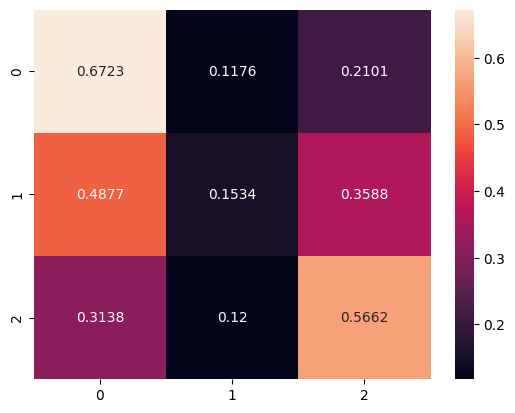

In [356]:
evaluation(y_val_pred, y_val, True)

Отличия между классами скорее вызвано несбалансированностью:

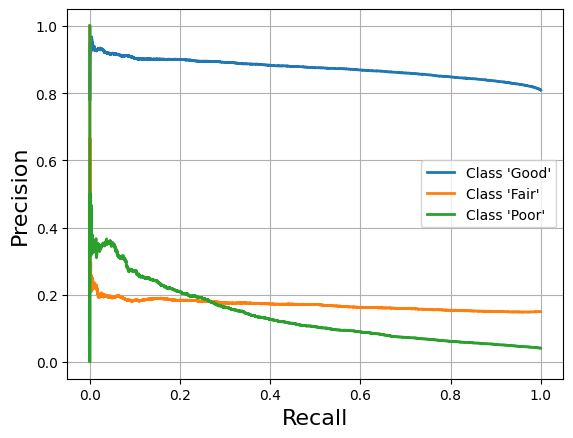

In [357]:
for i in range(3):
    xgb_precision, xgb_recall, thresholds = precision_recall_curve(y_val_binarized[:, i], y_val_pred_scores[:, i])
    label = 'Class ' + "'" + str(definitions_val[i]) + "'"
    plot_precision_recall(xgb_precision, xgb_recall, label)

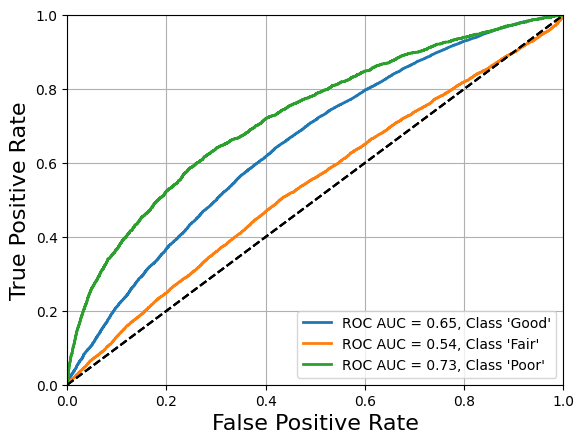

In [358]:
for i in range(3):
    fpr_xgb, tpr_xgb, thresholds = roc_curve(y_val_binarized[:, i], y_val_pred_scores[:, i])
    xgb_roc_auc = roc_auc_score(y_val_binarized[:, i], y_val_pred_scores[:, i])
    label = ', Class ' + "'" + str(definitions_val[i]) + "'"
    plot_roc_curve(fpr_xgb, tpr_xgb, xgb_roc_auc, label)

In [359]:
res = []
for l in [0, 1, 2]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(y_val) == l,
                                                  np.array(y_val_pred) == l,
                                                  pos_label = True, average = None)
     res.append([l, recall[1], recall[0]])
    
pd.DataFrame(res,columns = ['class', 'sensitivity', 'specificity'])

,class,sensitivity,specificity
0,0,0.672316,0.549632
1,1,0.153415,0.882260
2,2,0.566190,0.766663


In [503]:
rr_df, gain_df, lift_df  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for i in range(3):
    cumulative_rr_values = cumulative_classification_responce_rate(y_val_binarized[:, i], y_val_pred_scores[:, i])
    cumulative_gain_values = cumulative_classification_gain(y_val_binarized[:, i], y_val_pred_scores[:, i])
    cumulative_lift_values = cumulative_classification_lift(y_val_binarized[:, i], y_val_pred_scores[:, i])
    
    col_name_rr = 'Cumulative Responce Rate (class ' + str(i) + ')'
    col_name_gain = 'Cumulative Gain (class ' + str(i) + ')'
    col_name_lift = 'Cumulative Lift (class ' + str(i) + ')'
    
    rr_df[col_name_rr] = cumulative_rr_values
    gain_df[col_name_gain] = cumulative_gain_values
    lift_df[col_name_lift] = cumulative_lift_values

rr_df['bins'] = pd.qcut(rr_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
rr_df = rr_df.groupby(['bins'], observed = False).mean()

gain_df['bins'] = pd.qcut(gain_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
gain_df = gain_df.groupby(['bins'], observed = False).mean()

lift_df['bins'] = pd.qcut(lift_df.index, q = 100, labels = np.arange(0, 100).astype('str').tolist())
lift_df = lift_df.groupby(['bins'], observed = False).mean()

По показателям «Gain» и «Lift» видно, что модель намного превосходит случайный отбор для класса 2 («Poor»), где значение Lift для первых 10 перцентилей в диапазоне 3-8. Также хороший результат для класса 0 («Good»), для которого данные показатели не слишком лучше случайного отбора, однако причиной тому является изначально высокая доля данного класса в совокупности (около 81% всех классов):

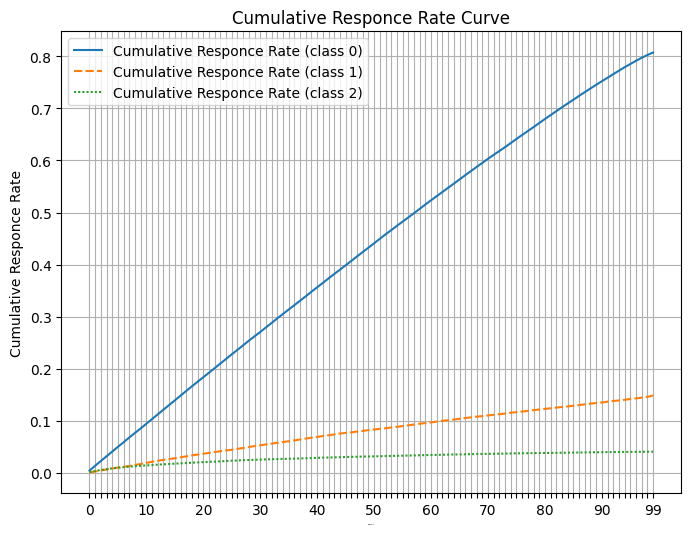

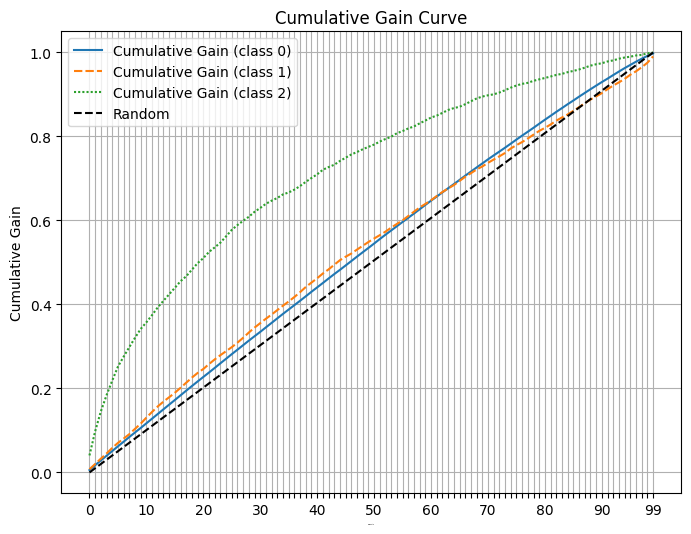

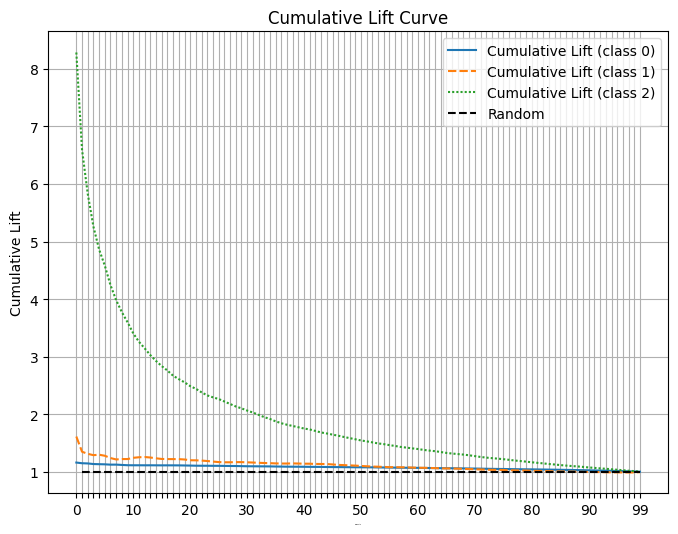

In [505]:
plot_cumulative_chart(rr_df, 'Cumulative Responce Rate')
plot_cumulative_chart(gain_df, 'Cumulative Gain')
plot_cumulative_chart(lift_df, 'Cumulative Lift')

# **Evaluation of Multilayer Perceptron(just for reference, not included in presentation)**

## **Preparation**

In [363]:
PATH = '\\Models\\model_mlp.tar'

model_mlp = MLP(30, 41, 19, 3)
model_mlp.load_state_dict(torch.load(PATH))
model_mlp.eval()

MLP(
  (layer1): Linear(in_features=30, out_features=41, bias=True)
  (layer2): Linear(in_features=41, out_features=19, bias=True)
  (layer3): Linear(in_features=19, out_features=3, bias=True)
  (bm_1): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bm_2): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [364]:
scaler_name = '\\Models\\MinMaxScaler.sav'
scaler = pickle.load(open(scaler_name, 'rb'))
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
y_test_numpy = y_test.to_numpy().copy()
y_val_numpy = y_val.to_numpy().copy()

In [365]:
testdata = Data(X_test_scaled, y_test_numpy)
testloader = DataLoader(testdata, batch_size = 500, shuffle = True)

validationdata = Data(X_val_scaled, y_val_numpy)
validationloader = DataLoader(validationdata, batch_size = 500, shuffle = True)

In [366]:
# Store predictions and true labels from test data
all_outputs, all_preds, all_labels  = [], [], []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model_mlp(inputs)
        _, predicted = torch.max(outputs, 1)
        all_outputs.extend(outputs.cpu().tolist())
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

all_outputs, all_preds, all_labels  = np.array(all_outputs), np.array(all_preds), np.array(all_labels)

all_preds_binarized = label_binarize(all_preds, classes = [*range(3)])
all_labels_binarized = label_binarize(all_labels, classes = [*range(3)])

In [367]:
# Store predictions and true labels from validation data
all_outputs_val, all_preds_val, all_labels_val  = [], [], []

with torch.no_grad():
    for inputs, labels in validationloader:
        outputs = model_mlp(inputs)
        _, predicted = torch.max(outputs, 1)
        all_outputs_val.extend(outputs.cpu().tolist())
        all_preds_val.extend(predicted.cpu().tolist())
        all_labels_val.extend(labels.cpu().tolist())

all_outputs_val, all_preds_val, all_labels_val  = np.array(all_outputs_val), np.array(all_preds_val), np.array(all_labels_val)

all_preds_val_binarized = label_binarize(all_preds_val, classes = [*range(3)])
all_labels_val_binarized = label_binarize(all_labels_val, classes = [*range(3)])

## **Main metrics**

Accuracy: 0.5364590526170419
              precision    recall  f1-score   support

           0    0.53555   0.64582   0.58554      4828
           1    0.43625   0.37000   0.40040      4827
           2    0.62746   0.59354   0.61003      4827

    accuracy                        0.53646     14482
   macro avg    0.53309   0.53645   0.53199     14482
weighted avg    0.53309   0.53646   0.53199     14482



0.5364590526170419

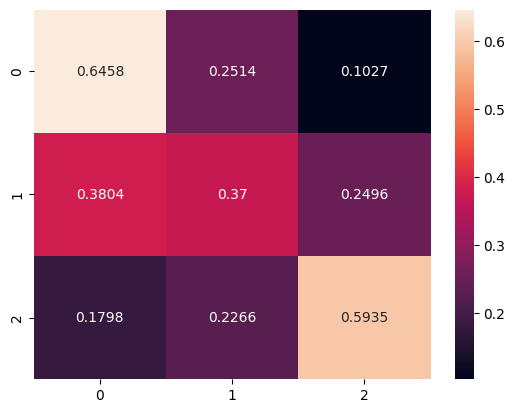

In [368]:
evaluation(all_preds, all_labels, True)

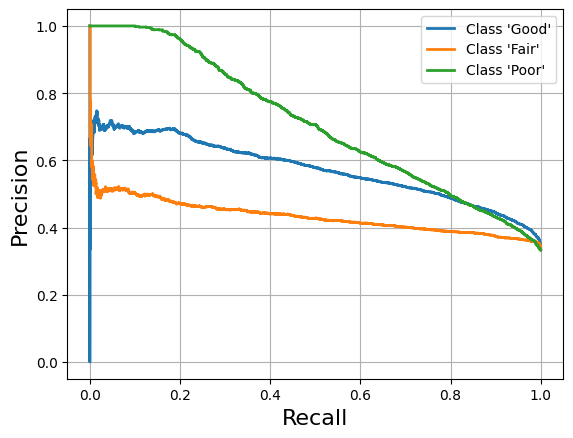

In [369]:
for i in range(3):
    mlp_precision, mlp_recall, thresholds = precision_recall_curve(all_labels_binarized[:, i], all_outputs[:, i])
    label = 'Class ' + "'" + str(definitions_val[i]) + "'"
    plot_precision_recall(mlp_precision, mlp_recall, label)

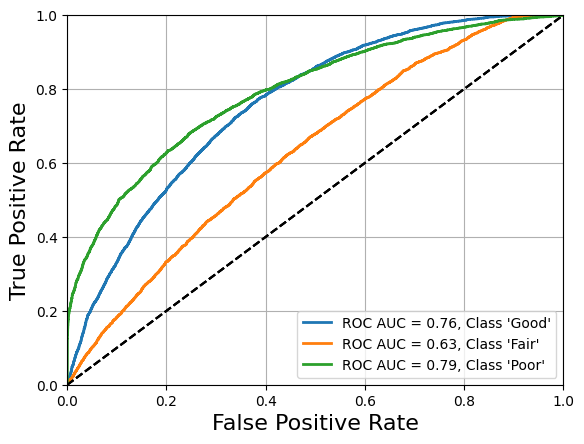

In [370]:
for i in range(3):
    fpr_mlp, tpr_mlp, thresholds = roc_curve(all_labels_binarized[:, i], all_outputs[:, i])
    mlp_roc_auc = roc_auc_score(all_labels_binarized[:, i], all_outputs[:, i])
    label = ', Class ' + "'" + str(definitions[i]) + "'"
    plot_roc_curve(fpr_mlp, tpr_mlp, mlp_roc_auc, label)

In [371]:
res = []
for l in [0, 1, 2]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(all_labels) == l,
                                                  np.array(all_preds) == l,
                                                  pos_label = True, average = None)
     res.append([l, recall[1], recall[0]])
    
pd.DataFrame(res,columns = ['class', 'sensitivity', 'specificity'])

,class,sensitivity,specificity
0,0,0.645816,0.719909
1,1,0.370002,0.760953
2,2,0.593536,0.823822


## **Gain, Responce Rate, Lift**

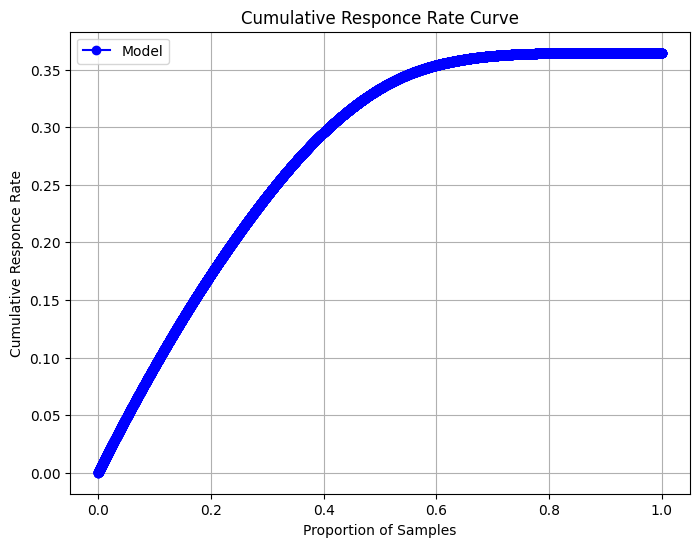

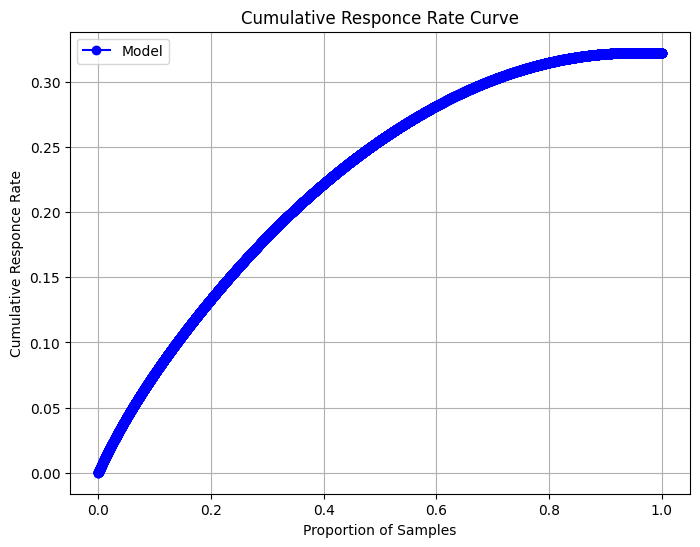

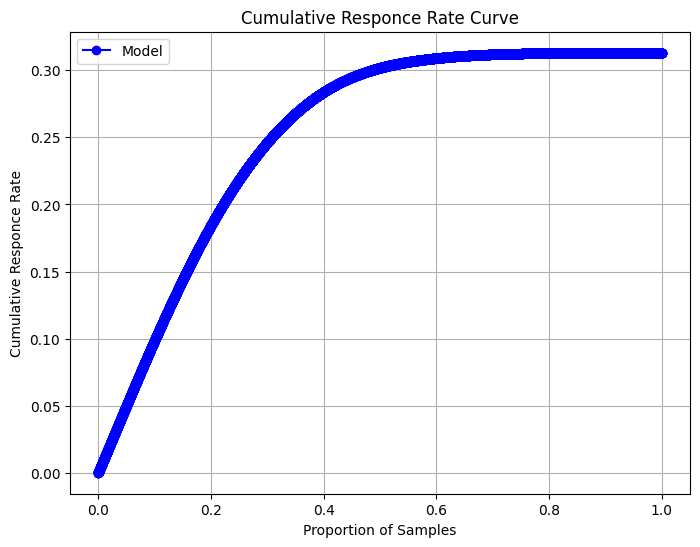

In [372]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_test) + 1) / len(y_test), cumulative_classification_responce_rate(all_labels_binarized[:, i], all_outputs[:, i]), marker='o', linestyle='-', color='b')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Responce Rate')
    plt.title('Cumulative Responce Rate Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()

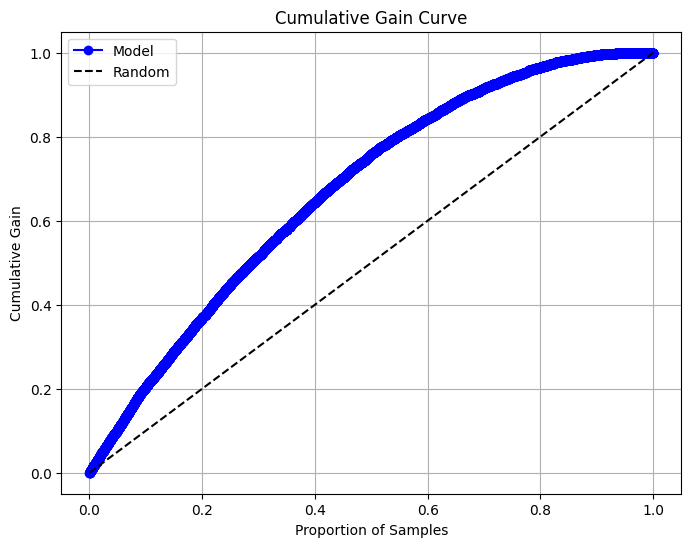

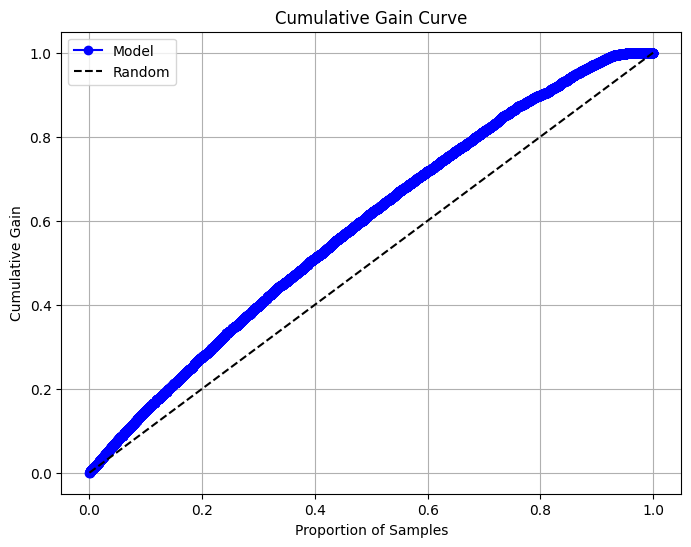

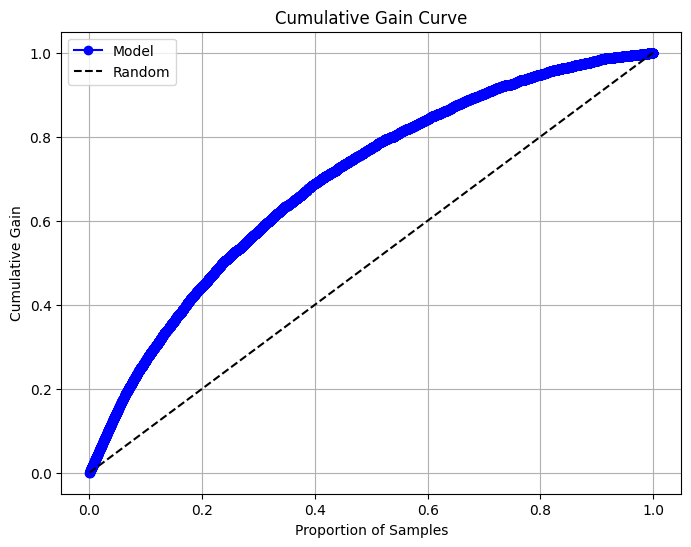

In [373]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_test) + 1) / len(y_test), cumulative_classification_gain(all_labels_binarized[:, i], all_outputs[:, i]), marker='o', linestyle='-', color='b')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Gain')
    plt.title('Cumulative Gain Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()

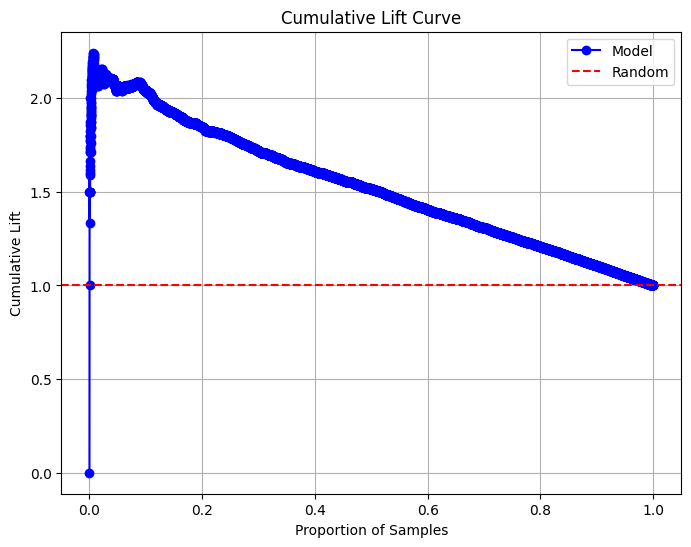

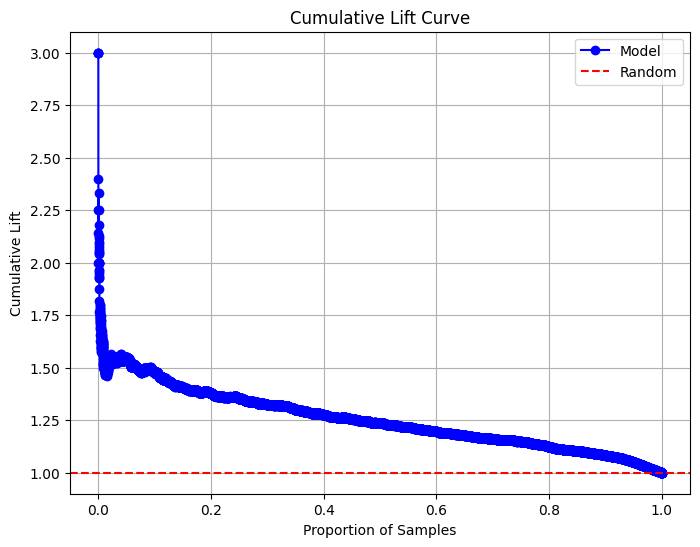

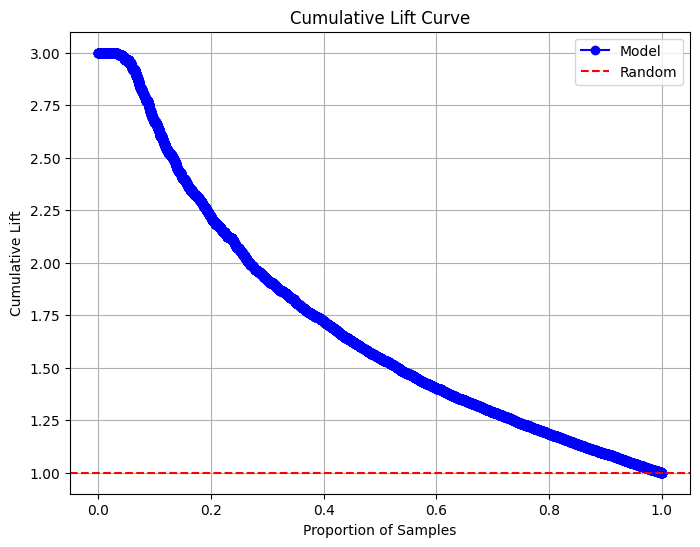

In [374]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_test) + 1) / len(y_test), cumulative_classification_lift(all_labels_binarized[:, i], all_outputs[:, i]), marker='o', linestyle='-', color='b')
    plt.axhline(y = 1, color = 'red', linestyle='--')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Lift')
    plt.title('Cumulative Lift Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()

## **Validation**

In [375]:
unique, counts = np.unique(all_preds_val, return_counts = True)
dict(zip(unique, counts))

{np.int64(0): np.int64(7449),
 np.int64(1): np.int64(2633),
 np.int64(2): np.int64(41050)}

Accuracy: 0.15819838848470624
              precision    recall  f1-score   support

           0    0.80709   0.14536   0.24635     41360
           1    0.13976   0.04797   0.07142      7672
           2    0.04163   0.81381   0.07921      2100

    accuracy                        0.15820     51132
   macro avg    0.32949   0.33571   0.13233     51132
weighted avg    0.67552   0.15820   0.21324     51132



0.15819838848470624

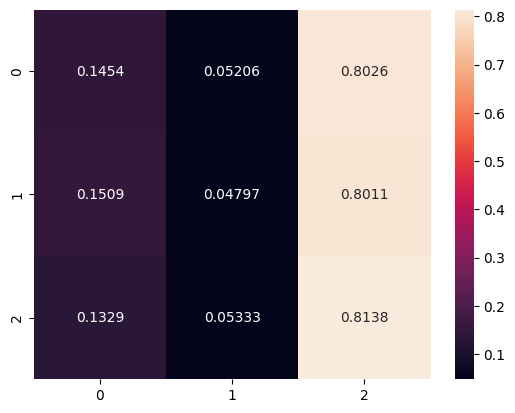

In [376]:
evaluation(all_preds_val, y_val, True)

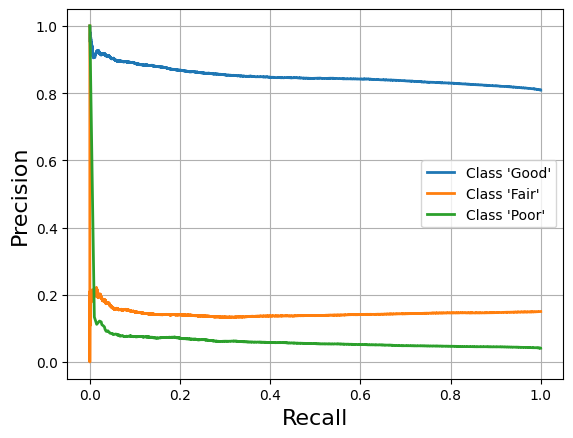

In [377]:
for i in range(3):
    mlp_precision, mlp_recall, thresholds = precision_recall_curve(all_labels_val_binarized[:, i], all_outputs_val[:, i])
    label = 'Class ' + "'" + str(definitions_val[i]) + "'"
    plot_precision_recall(mlp_precision, mlp_recall, label)

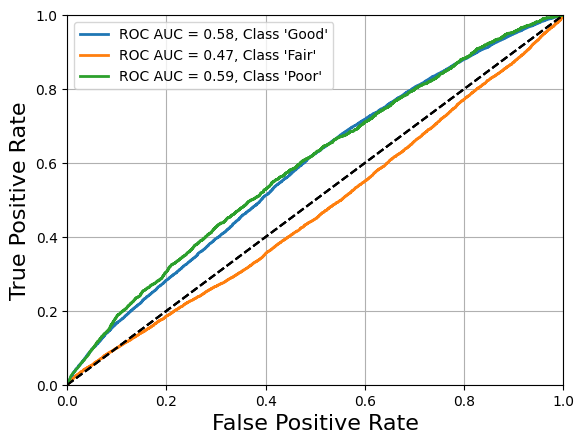

In [378]:
for i in range(3):
    fpr_mlp, tpr_mlp, thresholds = roc_curve(all_labels_val_binarized[:, i], all_outputs_val[:, i])
    mlp_roc_auc = roc_auc_score(all_labels_val_binarized[:, i], all_outputs_val[:, i])
    label = ', Class ' + "'" + str(definitions[i]) + "'"
    plot_roc_curve(fpr_mlp, tpr_mlp, mlp_roc_auc, label)

In [379]:
res = []
for l in [0, 1, 2]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(all_labels_val) == l,
                                                  np.array(all_preds_val) == l,
                                                  pos_label = True, average = None)
     res.append([l, recall[1], recall[0]])
    
pd.DataFrame(res,columns = ['class', 'sensitivity', 'specificity'])

,class,sensitivity,specificity
0,0,0.157882,0.905956
1,1,0.055266,0.949172
2,2,0.880476,0.200502


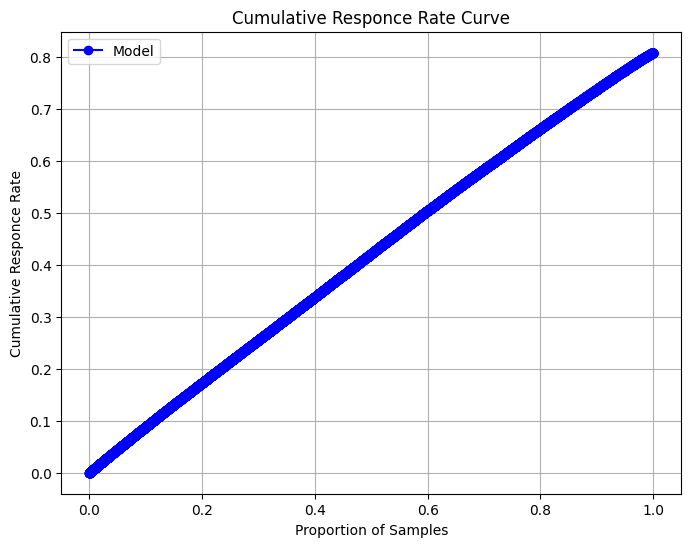

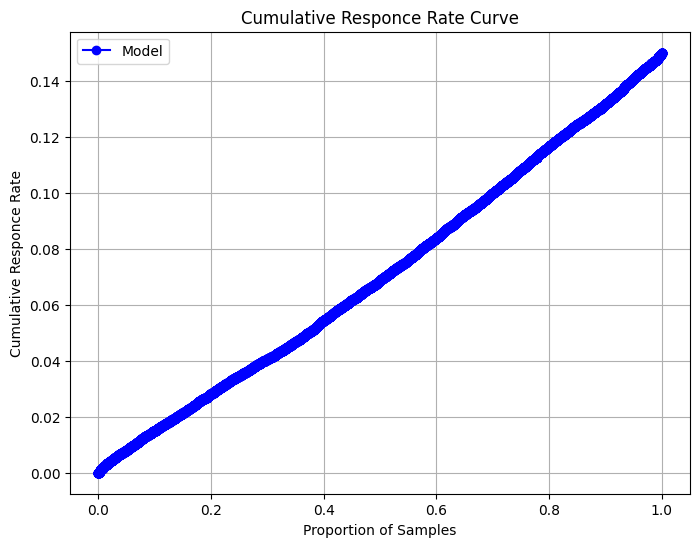

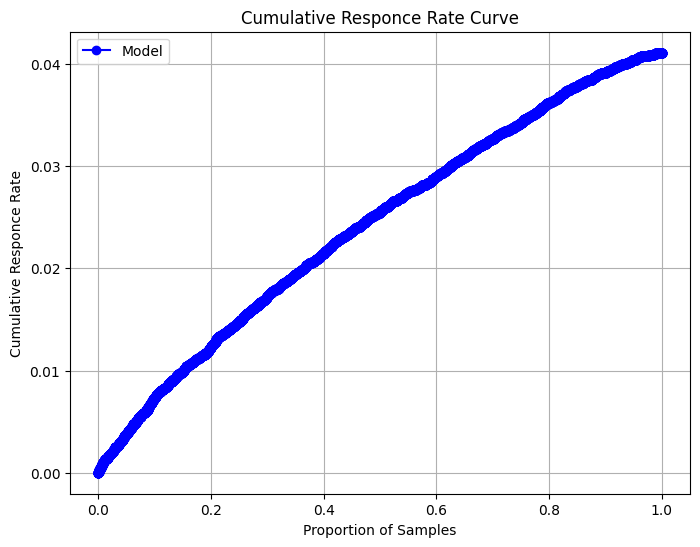

In [386]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_val) + 1) / len(y_val), cumulative_classification_responce_rate(all_labels_val_binarized[:, i], all_outputs_val[:, i]), marker='o', linestyle='-', color='b')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Responce Rate')
    plt.title('Cumulative Responce Rate Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()

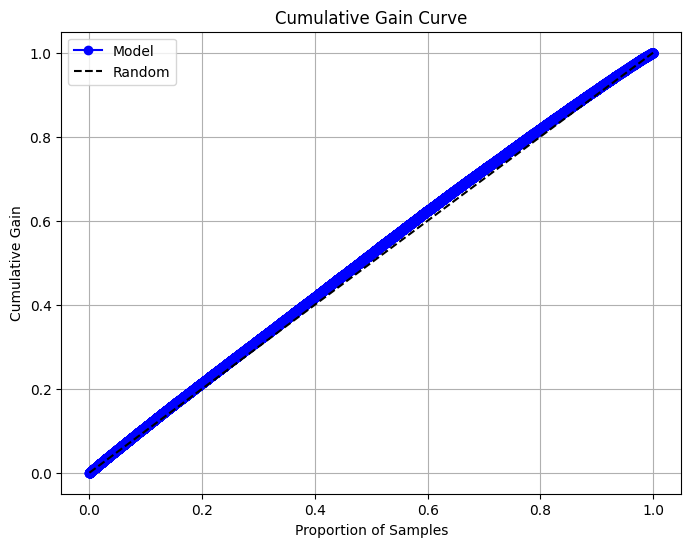

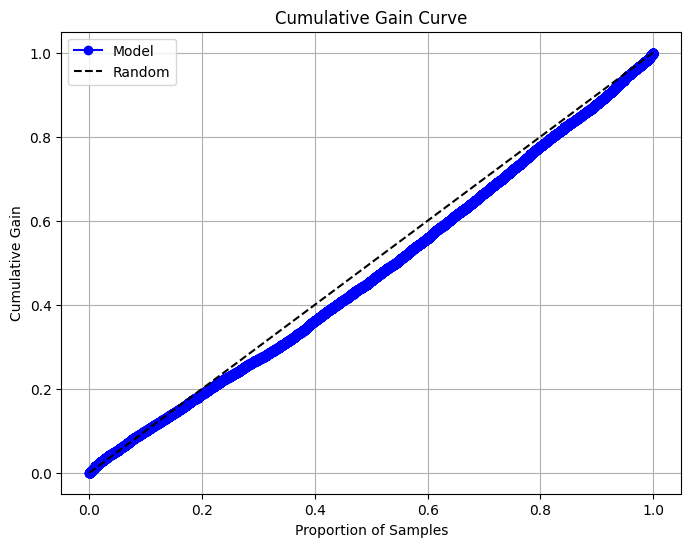

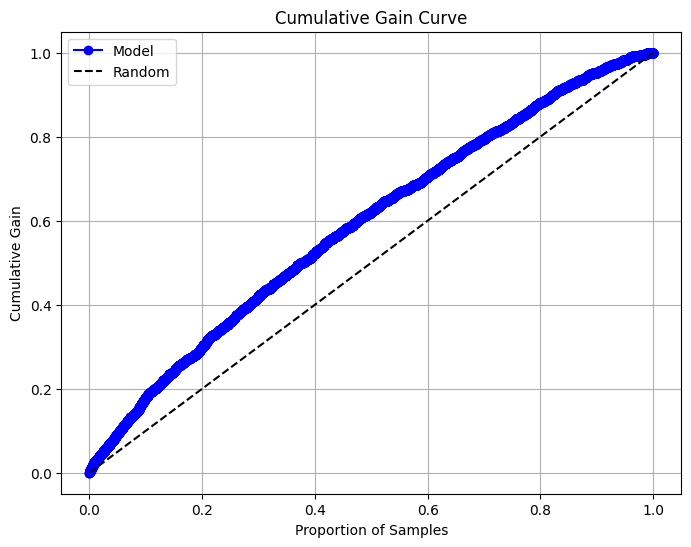

In [381]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_val) + 1) / len(y_val), cumulative_classification_gain(all_labels_val_binarized[:, i], all_outputs_val[:, i]), marker='o', linestyle='-', color='b')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Gain')
    plt.title('Cumulative Gain Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()

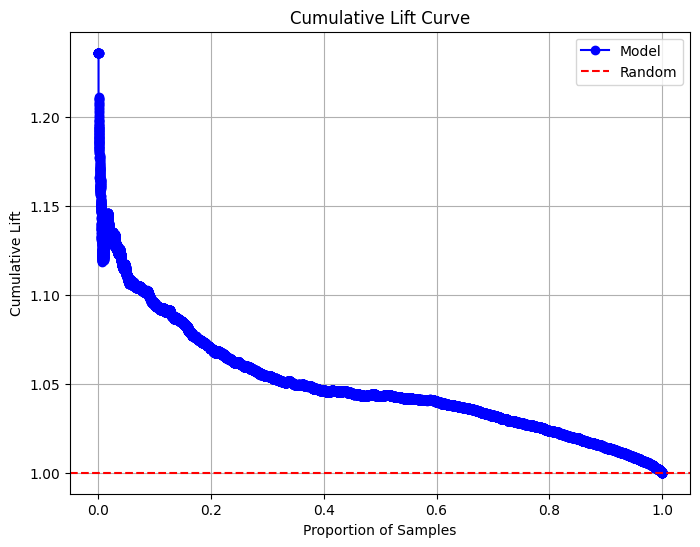

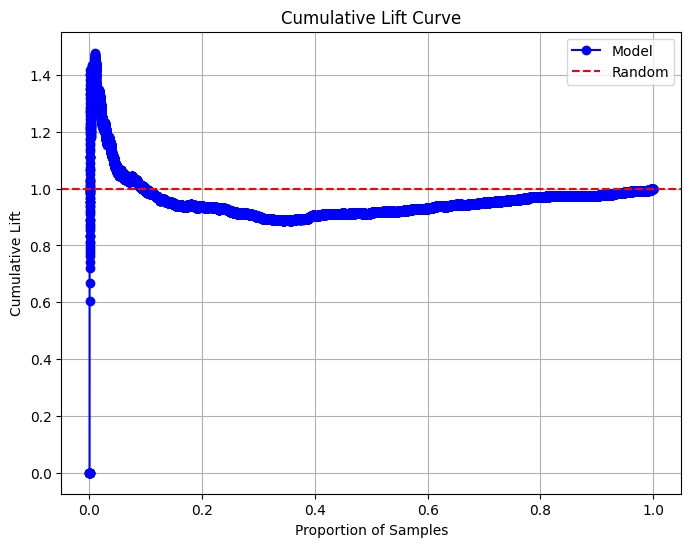

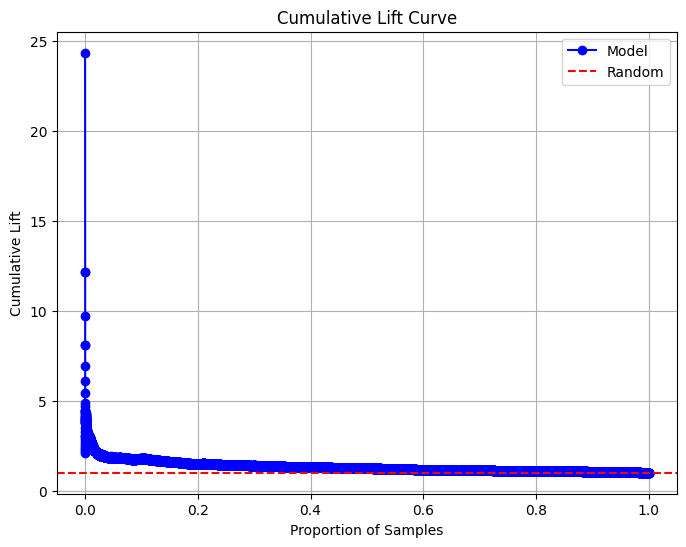

In [382]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(y_val) + 1) / len(y_val), cumulative_classification_lift(all_labels_val_binarized[:, i], all_outputs_val[:, i]), marker='o', linestyle='-', color='b')
    plt.axhline(y = 1, color = 'red', linestyle='--')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Lift')
    plt.title('Cumulative Lift Curve')
    plt.legend(['Model', 'Random'])
    plt.grid(True)
    plt.show()